# Data Visualization - Flight Delays

In this notebook, we look at flight delay data for 2018 from [US Bureau of Transportation Statistics](https://www.transtats.bts.gov/DL_SelectFields.asp?Table_ID=236&DB_Short_Name=On-Time). We want to see if we can predict flight delays using **linear regression**. We will first try to better understand the data using a bunch of visualization methods. (The visualizations are done on a random sample of the dataset (which is quite large) for performance reasons.) Then, we will see if we can predict flight delays. 

To start with, some information about the data: 

## Columns

1. QUARTER, MONTH, DAY_OF_MONTH, DAY_OF_WEEK, FL_DATE, OP_CARRIER 
2. ORIGIN_AIRPORT_ID, ORIGIN, ORIGIN_CITY_NAME, ORIGIN_STATE_ABR, ORIGIN_STATE_NM
3. DEST_AIRPORT_ID, DEST, DEST_CITY_NAME, DEST_STATE_ABR, DEST_STATE_NM
4. CRS_DEP_TIME, DEP_TIME, DEP_DELAY, DEP_DELAY_NEW, DEP_DEL15, DEP_DELAY_GROUP
5. CRS_ARR_TIME, ARR_TIME, ARR_DELAY, ARR_DELAY_NEW, ARR_DEL15, ARR_DELAY_GROUP 
6. CANCELLED, CANCELLATION_CODE, DIVERTED
7. CRS_ELAPSED_TIME, ACTUAL_ELAPSED_TIME, AIR_TIME, DISTANCE, DISTANCE_GROUP
8. CARRIER_DELAY, WEATHER_DELAY, NAS_DELAY, SECURITY_DELAY, LATE_AIRCRAFT_DELAY 
9. FIRST_DEP_TIME, TOTAL_ADD_GTIME 

## Column Definitions 

1. CRS_DEP/ARR_TIME = Computerized Reservation System = Scheduled Departure/Arrival Times 
2. DEP/ARR_TIME = Actual Departure/Arrival Time 
3. DEP/ARR_DELAY = Actual - Scheduled in minutes (negative = early)
4. DEP/ARR_DELAY_NEW = Actual - Scheduled in minutes (early departures/arrivals set to 0)
5. DEP/ARR_DELAY_GROUP = group delays in 15 minute chunks (< -15 to 180+)
6. CANCELLED, DIVERTED = 1 if flight was cancelled, diverted 
7. *_DELAY = delay in minutes
8. FIRST_DEP_TIME = first gate departure time at origin airport 
9. TOTAL_ADD_GTIME = total ground time away from gate for gate return or cancelled flights

## Generated Columns 

1. Origin/Destination Region = Census region that the origin airport state belongs to (+ US Territories)

In [273]:
import glob
import datetime
import numpy as np
import pandas as pd

from matplotlib import pyplot as plt, ticker as ticker, dates as mdates
import seaborn as sns

%matplotlib inline

from IPython.display import display, display_html
from numpy import median

In [3]:
def get_flight_data():
    flight_files = glob.glob('data/2018-*.csv')
    dataframes = []

    column_names = pd.read_csv(flight_files[0], nrows=0).columns
    int_columns = ['QUARTER', 'MONTH', 'DAY_OF_MONTH', 'DAY_OF_WEEK', 
                   'DEP_DELAY', 'DEP_DELAY_NEW', 'DEP_DEL15', 'DEP_DELAY_GROUP', 
                   'ARR_DELAY', 'ARR_DELAY_NEW', 'ARR_DEL15', 'ARR_DELAY_GROUP', 
                   'CANCELLED', 'DIVERTED', 
                   'CRS_ELAPSED_TIME', 'ACTUAL_ELAPSED_TIME', 'AIR_TIME', 'DISTANCE', 'DISTANCE_GROUP',
                   'CARRIER_DELAY', 'WEATHER_DELAY', 'NAS_DELAY', 'SECURITY_DELAY', 'LATE_AIRCRAFT_DELAY', 
                   'TOTAL_ADD_GTIME']

    types = { col: 'object' if col not in int_columns else 'Int64' for col in column_names }

    for filename in flight_files:
        print(f'Reading {filename}')
        df = pd.read_csv(filename, index_col=None, header=0, dtype = types)
        dataframes.append(df)

    df = pd.concat(dataframes, axis=0, ignore_index=True)
    df = df.sort_values(by=['MONTH', 'DAY_OF_MONTH'])
    
    return df
    
df = get_flight_data()

Reading data/2018-06.csv
Reading data/2018-12.csv
Reading data/2018-07.csv
Reading data/2018-11.csv
Reading data/2018-05.csv
Reading data/2018-04.csv
Reading data/2018-10.csv
Reading data/2018-01.csv
Reading data/2018-03.csv
Reading data/2018-02.csv
Reading data/2018-09.csv
Reading data/2018-08.csv


In [5]:
df = df[df['DEP_DELAY'].notna()]
df = df[df['ARR_DELAY'].notna()]

df['FL_DATE'] = pd.to_datetime(df['FL_DATE'])

def convert_to_time(raw_time):
    if pd.isnull(raw_time):
        return np.nan
    
    if raw_time == '2400':
        return datetime.time()
    
    return datetime.time(int(raw_time[:2]), int(raw_time[2:]))


df['SCHED_DEP_TIME'] = df.apply(lambda row: convert_to_time(row['CRS_DEP_TIME']), axis = 1)
df['ACT_DEP_TIME'] = df.apply(lambda row: convert_to_time(row['DEP_TIME']), axis = 1)

df['SCHED_ARR_TIME'] = df.apply(lambda row: convert_to_time(row['CRS_ARR_TIME']), axis = 1)
df['ACT_ARR_TIME'] = df.apply(lambda row: convert_to_time(row['ARR_TIME']), axis = 1)

In [6]:
# https://en.wikipedia.org/wiki/List_of_regions_of_the_United_States#/media/File:Census_Regions_and_Division_of_the_United_States.svg

def get_state_region(state_abbr):
    pacific = ['WA', 'OR', 'CA', 'AK', 'HI']
    mountain = ['MT', 'ID', 'WY', 'NV', 'UT', 'CO', 'AZ', 'NM']
    midwest_northwest = ['ND', 'SD', 'MN', 'NE', 'IA', 'KS', 'MO']
    midwest_southcentral = ['OK', 'AR', 'LA', 'TX']
    midwest_northeast = ['WI', 'MI', 'IL', 'IN', 'OH']
    midwest_southeast = ['KY', 'TN', 'MS', 'AL']
    new_england = ['ME', 'VT', 'NH', 'MA', 'CT', 'RI']
    mid_atlantic = ['NY', 'PA', 'NJ']
    south_atlantic = ['DE', 'MD', 'WV', 'DC', 'VA', 'NC', 'SC', 'GA', 'FL']
    
    if pd.isnull(state_abbr):
        return ''
    
    if state_abbr in pacific: 
        return 'Pacific'
    elif state_abbr in mountain: 
        return 'Mountain'
    elif state_abbr in midwest_northwest:
        return 'West North Central'
    elif state_abbr in midwest_southcentral:
        return 'West South Central'
    elif state_abbr in midwest_northeast:
        return 'East North Central'
    elif state_abbr in midwest_southeast:
        return 'East South Central'
    elif state_abbr in new_england:
        return 'New England'
    elif state_abbr in mid_atlantic:
        return 'Mid Atlantic'
    elif state_abbr in south_atlantic: 
        return 'South Atlantic'
    else:
        return 'US Territories'
    
df['ORIGIN_REGION'] = df.apply(lambda row: get_state_region(row['ORIGIN_STATE_ABR']), axis=1)  
df['DEST_REGION'] = df.apply(lambda row: get_state_region(row['DEST_STATE_ABR']), axis=1)

In [8]:
df.to_pickle('data/flights.pickle')

df = pd.read_pickle('data/flights.pickle')

df.shape

(7071818, 50)

In [637]:
df.dtypes

QUARTER                         Int64
MONTH                           Int64
DAY_OF_MONTH                    Int64
DAY_OF_WEEK                     Int64
FL_DATE                datetime64[ns]
OP_CARRIER                     object
ORIGIN_AIRPORT_ID              object
ORIGIN                         object
ORIGIN_CITY_NAME               object
ORIGIN_STATE_ABR               object
ORIGIN_STATE_NM                object
DEST_AIRPORT_ID                object
DEST                           object
DEST_CITY_NAME                 object
DEST_STATE_ABR                 object
DEST_STATE_NM                  object
CRS_DEP_TIME                   object
DEP_TIME                       object
DEP_DELAY                       Int64
DEP_DELAY_NEW                   Int64
DEP_DEL15                       Int64
DEP_DELAY_GROUP                 Int64
CRS_ARR_TIME                   object
ARR_TIME                       object
ARR_DELAY                       Int64
ARR_DELAY_NEW                   Int64
ARR_DEL15   

In [10]:
df.head().T

,5412933,5412966,5413005,5413007,5413030
QUARTER,1,1,1,1,1
MONTH,1,1,1,1,1
DAY_OF_MONTH,1,1,1,1,1
DAY_OF_WEEK,1,1,1,1,1
FL_DATE,2018-01-01 00:00:00,2018-01-01 00:00:00,2018-01-01 00:00:00,2018-01-01 00:00:00,2018-01-01 00:00:00
OP_CARRIER,9E,9E,9E,9E,9E
ORIGIN_AIRPORT_ID,15380,13871,13487,12339,14635
ORIGIN,TVC,OMA,MSP,IND,RSW
ORIGIN_CITY_NAME,"Traverse City, MI","Omaha, NE","Minneapolis, MN","Indianapolis, IN","Fort Myers, FL"
ORIGIN_STATE_ABR,MI,NE,MN,IN,FL


In [16]:
sample = df.sample(n=100000)

## What to Predict 

What we are interested in predicting is the flight delay, but there are two variables dealing with delay -- `DEP_DELAY` and `ARR_DELAY`. Which one of these is more interesting? That probably depends on the consumer of the data (airlines may care about both, for example, while a stakeholder at the origin airport might only care about `DEP_DELAY`). For passengers, the more important one is probably the `ARR_DELAY` -- what we really want to know is whether we arrived at the destination on time, not whether we took off on time. But is there a difference between the two? Can you take off on time and arrive late? (Intuitively, the answer is yes.) Can you take off late and arrive on time? Possibly (maybe we have a tail wind, etc.) 

Let's start by looking at the relationship between departure and arrival delays. 

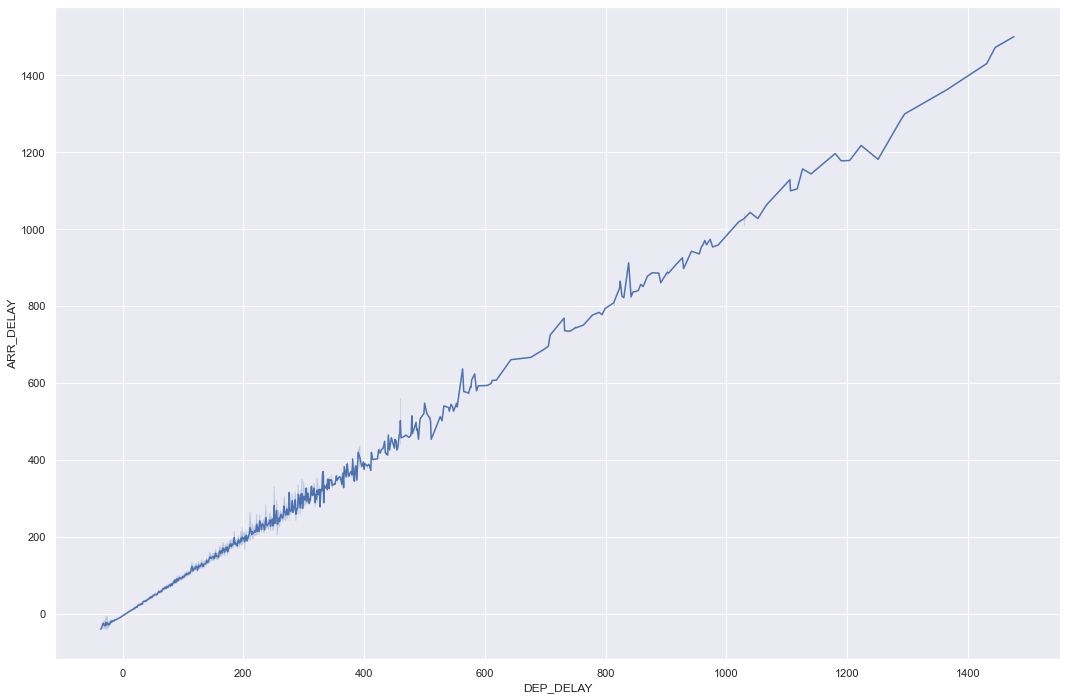

In [118]:
sns.set_theme()

fig, ax = plt.subplots(figsize=(18,12))
sns.lineplot(ax=ax, 
             x='DEP_DELAY', y='ARR_DELAY', 
             data=sample.astype({'DEP_DELAY': 'float64', 'ARR_DELAY': 'float64'}))
plt.show()

(I needed to cast the delay columns to float to stop matplotlib from complaining about `ufunc isfinite` not being able to work with ints.)

The graph shows that departure delays and arrival delays are roughly correlated -- if we take off late, we can expect to land late, too, and by roughly the same amount. Let's break this by airline to see how the airlines do. We will use bars to show the arrival and departure delays by airline. 

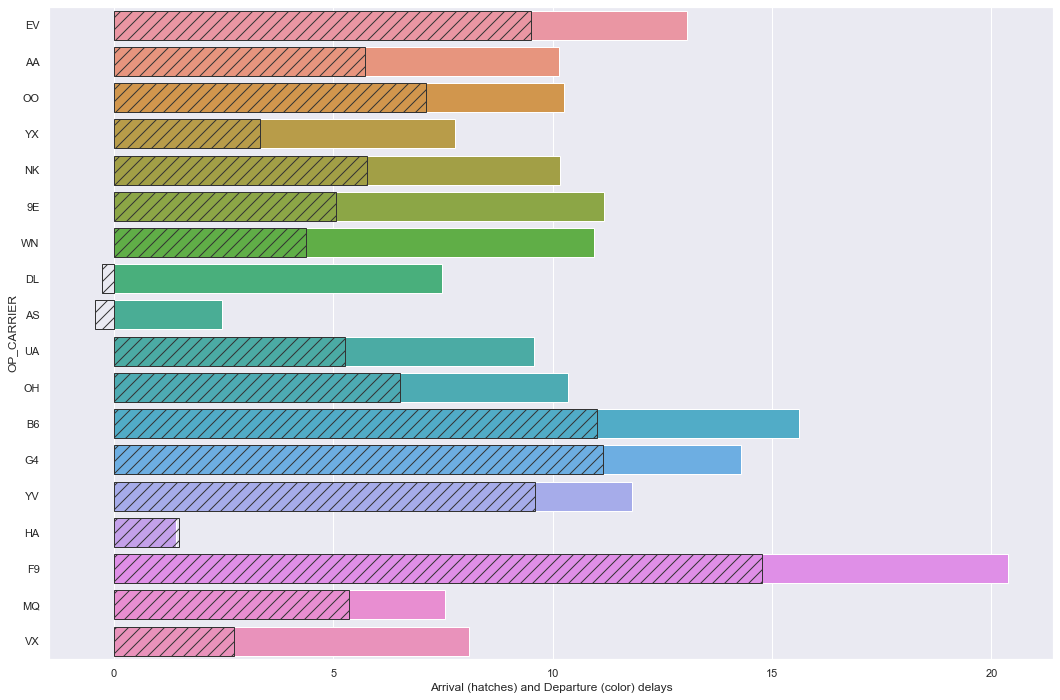

In [125]:
fig, ax = plt.subplots(figsize=(18,12))
sns.barplot(ax=ax, x='DEP_DELAY', y='OP_CARRIER', data=sample, ci=None)
sns.barplot(ax=ax, x='ARR_DELAY', y='OP_CARRIER', data=sample, ci=None, fill=False, hatch='//', edgecolor=['#333'])
ax.set(xlabel='Arrival (hatches) and Departure (color) delays')

plt.show()

Interestingly, this graph shows that airlines are much better at arriving on time (or closer to on time) than they are at departing on time (except in the case of HA = Hawaiian Airlines). Is that right? That doesn't seem to jive with the line graph above. Let's look at the data: 

In [159]:
def get_summary_statistics(group):
    return {
        'min': group.min(),
        'max': group.max(),
        'mean': group.mean(),
        'std': group.std(),
        'count': group.count()
    }

display(sample['DEP_DELAY'] \
    .groupby(sample['OP_CARRIER']) \
    .apply(get_summary_statistics) \
    .unstack() \
    .T)

display(sample['ARR_DELAY'] \
    .groupby(sample['OP_CARRIER']) \
    .apply(get_summary_statistics) \
    .unstack() \
    .T)

display(sample[['OP_CARRIER', 'DEP_DELAY', 'ARR_DELAY']] \
    .groupby('OP_CARRIER') \
    .agg('mean') \
    .T)

OP_CARRIER,9E,AA,AS,B6,DL,EV,F9,G4,HA,MQ,NK,OH,OO,UA,VX,WN,YV,YX
min,-21.000000,-23.000000,-34.000000,-22.000000,-23.000000,-25.000000,-34.000000,-31.000000,-17.000000,-25.000000,-23.000000,-31.000000,-36.000000,-28.000000,-20.000000,-12.000000,-26.000000,-23.000000
max,1126.000000,1476.000000,461.000000,576.000000,955.000000,1029.000000,577.000000,612.000000,1251.000000,1106.000000,1295.000000,773.000000,1431.000000,1365.000000,381.000000,499.000000,1287.000000,1223.000000
mean,11.171655,10.138071,2.464548,15.605714,7.486412,13.068057,20.373063,14.287801,1.412310,7.552144,10.156276,10.346386,10.248324,9.585536,8.092050,10.951153,11.798093,7.770461
std,54.437314,46.919213,28.674953,49.553662,38.465743,66.655853,56.679814,52.073796,41.626178,37.998733,58.265901,41.667525,57.727878,47.862396,40.411641,29.799337,58.912376,44.256281
count,3274.000000,12805.000000,3399.000000,4200.000000,13394.000000,2733.000000,1678.000000,1369.000000,1186.000000,3941.000000,2406.000000,3652.000000,10889.000000,8587.000000,239.000000,18998.000000,2937.000000,4313.000000


OP_CARRIER,9E,AA,AS,B6,DL,EV,F9,G4,HA,MQ,NK,OH,OO,UA,VX,WN,YV,YX
min,-59.000000,-74.000000,-86.000000,-68.000000,-66.000000,-47.000000,-66.000000,-61.000000,-49.000000,-57.000000,-69.000000,-47.000000,-87.000000,-62.000000,-61.000000,-51.000000,-51.000000,-59.000000
max,1157.000000,1501.000000,458.000000,591.000000,936.000000,1043.000000,589.000000,607.000000,1182.000000,1100.000000,1300.000000,768.000000,1431.000000,1363.000000,403.000000,521.000000,1280.000000,1218.000000
mean,5.069945,5.728153,-0.436011,11.000714,-0.266836,9.502744,14.765197,11.152666,1.479764,5.365643,5.765586,6.512048,7.119846,5.266216,2.728033,4.370776,9.602996,3.340830
std,57.193015,49.718970,32.024765,51.684741,41.033787,68.136477,58.568062,54.082182,40.352268,41.218318,60.950482,43.193337,59.492881,50.498341,45.219786,32.028845,60.134078,46.645962
count,3274.000000,12805.000000,3399.000000,4200.000000,13394.000000,2733.000000,1678.000000,1369.000000,1186.000000,3941.000000,2406.000000,3652.000000,10889.000000,8587.000000,239.000000,18998.000000,2937.000000,4313.000000


OP_CARRIER,9E,AA,AS,B6,DL,EV,F9,G4,HA,MQ,NK,OH,OO,UA,VX,WN,YV,YX
DEP_DELAY,11.171655,10.138071,2.464548,15.605714,7.486412,13.068057,20.373063,14.287801,1.412310,7.552144,10.156276,10.346386,10.248324,9.585536,8.092050,10.951153,11.798093,7.770461
ARR_DELAY,5.069945,5.728153,-0.436011,11.000714,-0.266836,9.502744,14.765197,11.152666,1.479764,5.365643,5.765586,6.512048,7.119846,5.266216,2.728033,4.370776,9.602996,3.340830


Airlines are definitely better at arriving closer to on-time than they are taking off on-time. But how do they do when we look specifically at the flights that had delayed take-offs?

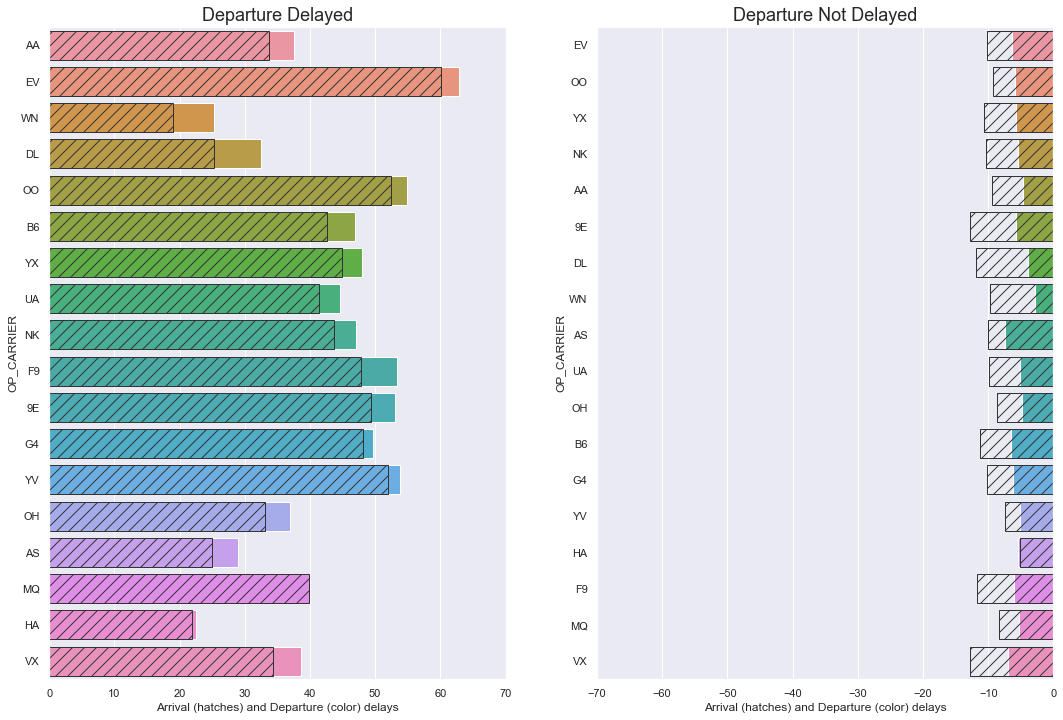

In [169]:
dep_delay_sample = sample[sample['DEP_DELAY'] > 0][['OP_CARRIER', 'DEP_DELAY', 'ARR_DELAY']]

fig, ax = plt.subplots(1, 2, figsize=(18,12))
sns.barplot(ax=ax[0], x='DEP_DELAY', y='OP_CARRIER', data=dep_delay_sample, ci=None)
sns.barplot(ax=ax[0], x='ARR_DELAY', y='OP_CARRIER', data=dep_delay_sample, ci=None, fill=False, hatch='//', edgecolor=['#333'])
ax[0].set(xlabel='Arrival (hatches) and Departure (color) delays')
ax[0].set(xlim=(0,70))
ax[0].set_title('Departure Delayed', fontsize=18)

dep_not_delayed_sample = sample[sample['DEP_DELAY'] <= 0][['OP_CARRIER', 'DEP_DELAY', 'ARR_DELAY']]

sns.barplot(ax=ax[1], x='DEP_DELAY', y='OP_CARRIER', data=dep_not_delayed_sample, ci=None)
sns.barplot(ax=ax[1], x='ARR_DELAY', y='OP_CARRIER', data=dep_not_delayed_sample, ci=None, fill=False, hatch='//', edgecolor=['#333'])
ax[1].set(xlabel='Arrival (hatches) and Departure (color) delays')
ax[1].set(xlim=(-70, 0))
ax[1].set_title('Departure Not Delayed', fontsize=18)

plt.show()

Ok, this makes more sense. Flights that take off late still usually arrive late, by roughly the same amount of time. Flights that take off on-time or early, though, arrive even earlier. Take-off delays are larger, but I'm guessing a lot more flights take off on-time or early, so the numbers match up with the summary graphs. 

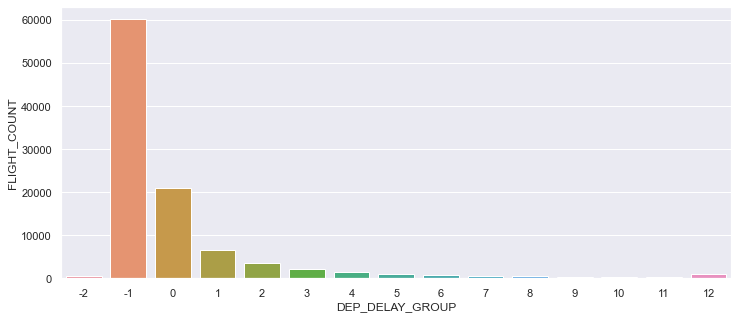

In [214]:
# "-2","Delay < -15 minutes"
# "-1","Delay between -15 and -1 minutes"
# "0","Delay between 0 and 14 minutes"
# "1","Delay between 15 to 29 minutes"
# "2","Delay between 30 to 44 minutes"
# "3","Delay between 45 to 59 minutes"
# "4","Delay between 60 to 74 minutes"
# "5","Delay between 75 to 89 minutes"
# "6","Delay between 90 to 104 minutes"
# "7","Delay between 105 to 119 minutes"
# "8","Delay between 120 to 134 minutes"
# "9","Delay between 135 to 149 minutes"
# "10","Delay between 150 to 164 minutes"
# "11","Delay between 165 to 179 minutes"
# "12","Delay >= 180 minutes"

dep_del_counts = sample[['DEP_DELAY_GROUP']] \
    .value_counts() \
    .rename_axis('DEP_DELAY_GROUP') \
    .reset_index(name='FLIGHT_COUNT')

fig, ax = plt.subplots(figsize=(12,5))

sns.barplot(ax=ax, x='DEP_DELAY_GROUP', y='FLIGHT_COUNT', data=dep_del_counts)
plt.show()

There were go -- over 60% of the flights took off early and around 20% of the flights took off roughly on-time (within 15 minutes). 

## Relevant features 

Now that we know more about the variable we are trying to predict (`ARR_DELAY`), let's look at the other variables to see which of them might be causing the delays. 

1. `MONTH` -- maybe: people fly more in some months than other months, and more flights may mean more delays 
2. `DAY_OF_MONTH` -- do we have similar number of flights throughout a month or are there differences?
3. `DAY_OF_WEEK` -- maybe: do people fly more on Mondays (business travel) or Fridays (leisure travel) than other days of the week?  
4. `OP_CARRIER` -- are some airlines worse than others? 
5. `ORIGIN` -- do busier airports have worse delays than the less busy ones (think ORD or LAX vs. MSP)
6. `ORIGIN_STATE_NM` -- same as 5, except at the state level; weather events that hit states unequally (snow, hurricanes, etc.) may come into play, as well 
7. `DEST`, `DEST_STATE_NM` -- same as 5 and 6
8. `DEP_TIME` -- you can imagine that delays compound as the day goes on, so when the flight is taking off might be relevant
9. ~`DEP_DELAY` -- this is probably the strongest predictor of `ARR_DEL`, but you don't need a ML model to tell you that, so this may not be that useful~ :-)
10. `DISTANCE` -- given what we found out above, seems like airlines may be able to make up time more easily on longer flights vs. shorter flights, so distance could be negatively correlated with arrival delays 

Let's look at the relationship between each variable and `ARR_DELAY`

### Flight Delays by Time Periods

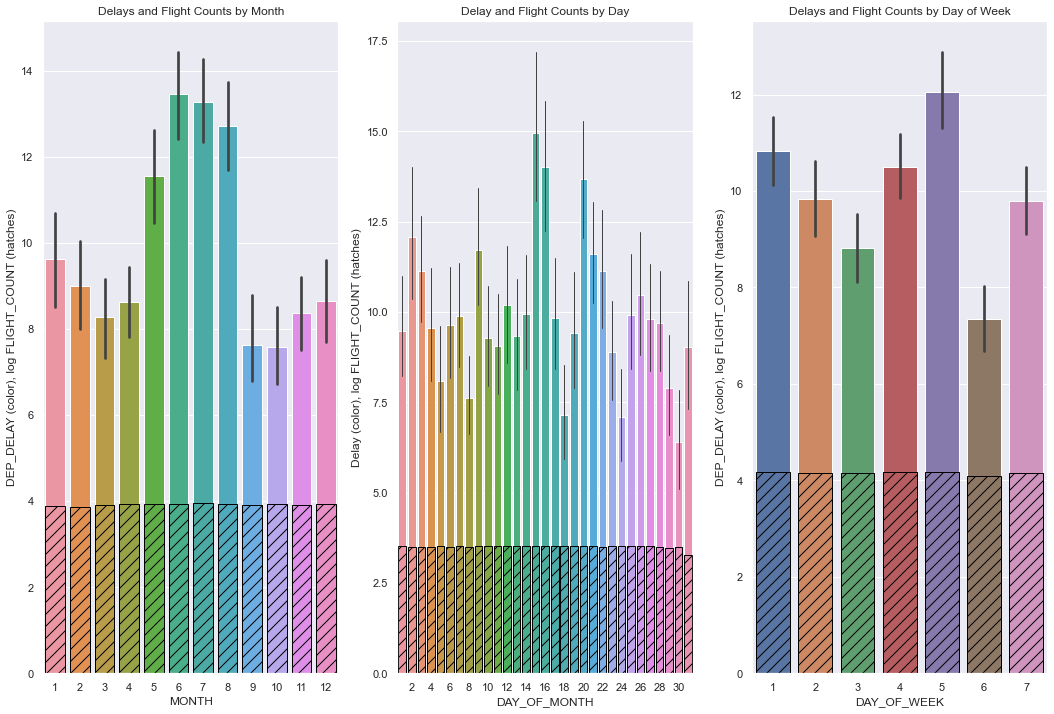

In [229]:
flights_by_month = sample['MONTH'].value_counts() \
    .rename_axis('MONTH') \
    .reset_index(name='FLIGHT_COUNT')
flights_by_day = sample['DAY_OF_MONTH'].value_counts() \
    .rename_axis('DAY_OF_MONTH') \
    .reset_index(name='FLIGHT_COUNT')
flights_by_day_of_week = sample['DAY_OF_WEEK'].value_counts() \
    .rename_axis('DAY_OF_WEEK') \
    .reset_index(name='FLIGHT_COUNT')

flights_by_month['FLIGHT_COUNT'] = np.log10(flights_by_month['FLIGHT_COUNT'])
flights_by_day['FLIGHT_COUNT'] = np.log10(flights_by_day['FLIGHT_COUNT'])
flights_by_day_of_week['FLIGHT_COUNT'] = np.log10(flights_by_day_of_week['FLIGHT_COUNT'])

fig, ax = plt.subplots(1, 3, figsize=(18,12))

sns.barplot(ax=ax[0], x='MONTH', y='DEP_DELAY', data=sample)
sns.barplot(ax=ax[0], x='MONTH', y='FLIGHT_COUNT', data=flights_by_month, ci=None, fill=False, hatch='//', edgecolor=['#000'])
ax[0].set(ylabel='DEP_DELAY (color), log FLIGHT_COUNT (hatches)')
ax[0].set_title('Delays and Flight Counts by Month', fontsize=12)

sns.barplot(ax=ax[1], x='DAY_OF_MONTH', y='DEP_DELAY', data=sample, errwidth=1)
sns.barplot(ax=ax[1], x='DAY_OF_MONTH', y='FLIGHT_COUNT', data=flights_by_day, ci=None, fill=False, hatch='//', edgecolor=['#000'])
ax[1].set(ylabel='Delay (color), log FLIGHT_COUNT (hatches)')
ax[1].set_title('Delay and Flight Counts by Day', fontsize=12)

for label in ax[1].xaxis.get_ticklabels()[::2]:
    label.set_visible(False)

sns.barplot(ax=ax[2], x='DAY_OF_WEEK', y='DEP_DELAY', data=sample)
sns.barplot(ax=ax[2], x='DAY_OF_WEEK', y='FLIGHT_COUNT', data=flights_by_day_of_week, ci=None, fill=False, hatch='//', edgecolor=['#000'])
ax[2].set(ylabel='DEP_DELAY (color), log FLIGHT_COUNT (hatches)')
ax[2].set_title('Delays and Flight Counts by Day of Week', fontsize=12)

plt.show()

You can see that delays show a repeating pattern in each grap, most clearly in the middle one (a peak near the start of the week and a smaller peak near the end). I thought it might have something to do with the number of flights, so I graphed that on top of the delays. But, surprisingly, we have around the same number of flights across time (Day 31 is probably an artifact of not every month having 31 days). **NOTE** that the flight counts are graphed in the logarithmic scale so they show up in the same scale as the delays. 

Let's try to graph the individual records across the whole time period to see if we can get additional insight. 

In [248]:
sample['FL_DATETIME'] = sample.apply(lambda row: datetime.datetime.combine(row['FL_DATE'], row['ACT_DEP_TIME']), axis=1)

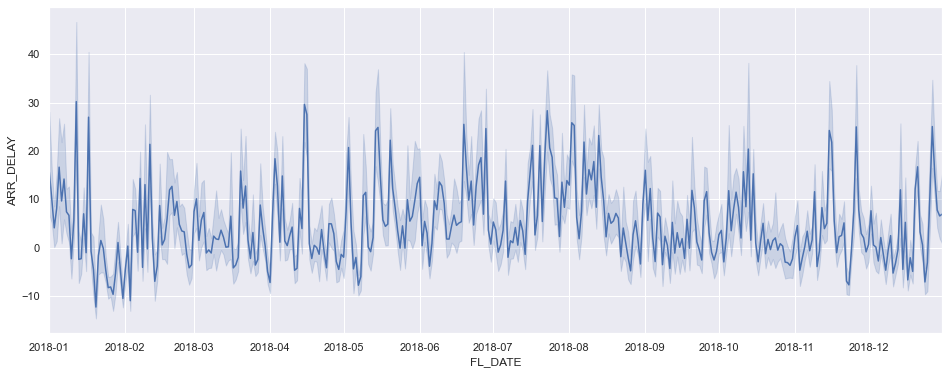

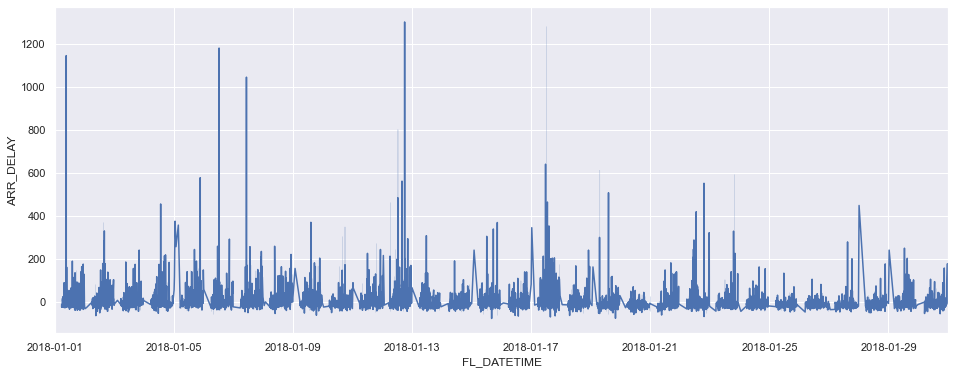

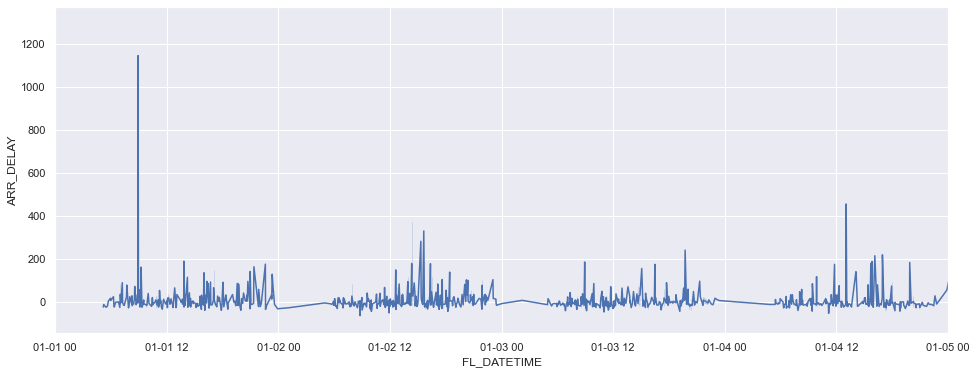

In [303]:
fig, ax = plt.subplots(figsize=(16,6))

sns.lineplot(ax=ax, x='FL_DATE', y='ARR_DELAY', data=sample.astype({'ARR_DELAY': 'float64'}))
ax.xaxis.set_major_locator(mdates.MonthLocator())
ax.set(xlim=('2018-01-01','2018-12-31'))

fig, ax = plt.subplots(figsize=(16,6))

sns.lineplot(ax=ax, x='FL_DATETIME', y='ARR_DELAY', \ 
             data=sample[sample['MONTH'] == 1].astype({'ARR_DELAY': 'float64'}))
ax.set(xlim=('2018-01-01','2018-01-31'))

fig, ax = plt.subplots(figsize=(16,6))

sns.lineplot(ax=ax, x='FL_DATETIME', y='ARR_DELAY', \ 
             data=sample[sample['MONTH'] == 1].astype({'ARR_DELAY': 'float64'}))
ax.set(xlim=('2018-01-01','2018-01-05'))

plt.show()

I don't really see much of a pattern with delays by day across the year (first graph), but you can definitely see a pattern when you look at flight delays by day in a month (second and third graphs), probably corresponding to day/night cycles. 

### Flight Delays by Airline

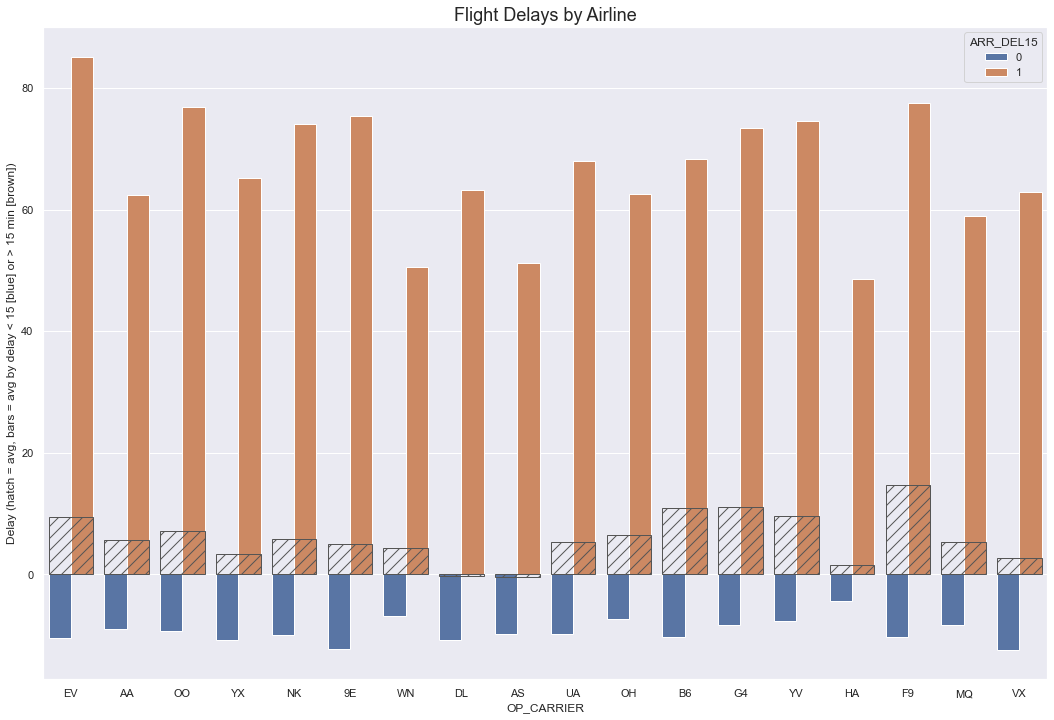

In [424]:
fig, ax = plt.subplots(figsize=(18,12))

sns.barplot(
    ax=ax, 
    x='OP_CARRIER', y='ARR_DELAY', 
    data=sample, 
    ci=None,
    hue='ARR_DEL15')

sns.barplot(
    ax=ax, 
    x='OP_CARRIER', 
    y='ARR_DELAY', 
    data=sample, 
    ci=None, fill=False, hatch='//', edgecolor=['#555'])

ax.set(ylabel='Delay (hatch = avg, bars = avg by delay < 15 [blue] or > 15 min [brown])')
ax.set_title('Flight Delays by Airline', fontsize=18)

plt.show()

What can we learn from this graph? 

1. The average delay is pretty consistent between airlines -- average delay ranges from ~1-17 minutes (with an average of maybe 8 minutes). 

2. There's not a huge variation between the airlines when it comes to on-time takeoffs/small delays (they appear to be close to around 10 minutes early) but there are larger variations in large delays (the smallest has an average of around 50 minutes while the largest has an average of around 90 minutes).

### Delays by Airport 

Next, let's look at what correlation, if any, there is between airports and flight delays.

In [425]:
sample['ORIGIN'].nunique()

350

Immediately, we see a problem. There are a lot of origin airports, which means that the data won't be easy to visualize with something like a `barplot` or a `lineplot`. 

Let's first start by plotting delays by regions that the airports belong to, to see if there are any differences. 

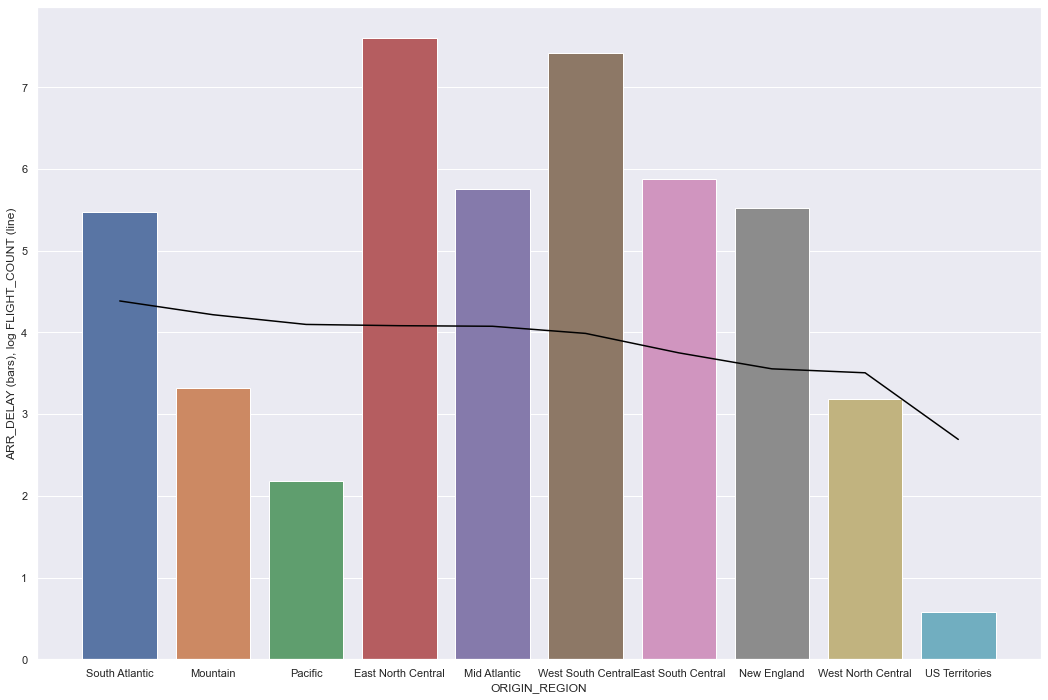

In [434]:
flights_by_region = sample['ORIGIN_REGION'].value_counts() \
    .rename_axis('ORIGIN_REGION') \
    .reset_index(name='FLIGHT_COUNT')

flights_by_region['FLIGHT_COUNT'] = np.log10(flights_by_region['FLIGHT_COUNT'])

fig, ax = plt.subplots(figsize=(18,12))

sns.barplot(
    ax=ax, 
    x='ORIGIN_REGION', y='ARR_DELAY', 
    data=sample, 
    ci=None)

sns.lineplot(ax=ax, x='ORIGIN_REGION', y='FLIGHT_COUNT', data=flights_by_region, color='#000')

ax.set(ylabel='ARR_DELAY (bars), log FLIGHT_COUNT (line)')

plt.show()

From the graph, it appears that South Atlantic does roughly 100 times as many flights as US Territories and 10 times as many flights as West North Central (remember that the y-axis is in the logarithmic scale, which means that an increase of 1 corresponds to an increase of 10x in the actual data). 

Mountain and Pacific airports see nearly as much traffic but seem way more efficient. This is in contrast to East North Central (which contains Illinois) and West South Central (which contains Texas), which show the two highest average delays. 

Let's next try to show delays by airports through a `scatterplot`, where the position of the circle indicates how delayed the airport is and the size of the circle shows how many flights take off from the airport. 

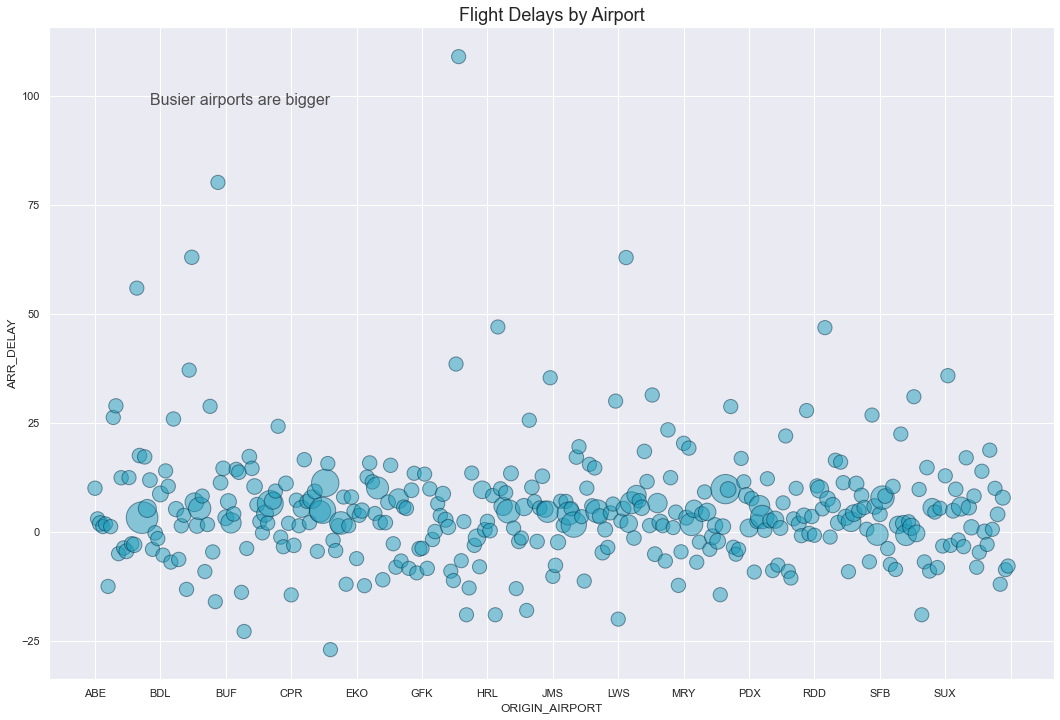

In [598]:
flights_by_origin = sample['ORIGIN'].value_counts() \
    .rename_axis('ORIGIN') \
    .reset_index(name='FLIGHT_COUNT') \
    .sort_values(by='ORIGIN')

delay_by_origin = sample['ARR_DELAY'] \
    .groupby(sample['ORIGIN']) \
    .apply(get_summary_statistics) \
    .unstack() \
    .sort_values(by='ORIGIN')

airport_stats = delay_by_origin.copy()
airport_stats['ORIGIN_AIRPORT'] = flights_by_origin['ORIGIN'].to_numpy()
airport_stats['FLIGHT_COUNT'] = flights_by_origin['FLIGHT_COUNT'].to_numpy()

fig, ax = plt.subplots(figsize=(18,12))

sns.scatterplot(
    ax=ax, 
    data=airport_stats, 
    x='ORIGIN_AIRPORT', 
    y='mean', 
    size='FLIGHT_COUNT', 
    sizes=(200,1000), 
    linewidth=1, 
    edgecolor='#023047', 
    facecolors='#219ebc', 
    alpha=0.5, 
    legend=False)

ax.xaxis.set_major_locator(ticker.MultipleLocator(25))
ax.yaxis.set_major_locator(ticker.MultipleLocator(25))

ax.set(ylabel='ARR_DELAY')
ax.set_title('Flight Delays by Airport', fontsize=18)
ax.text(
    s='Busier airports are bigger', 
    fontsize=16, 
    x = 0.1, 
    y = 0.9, 
    ha='left', 
    va='top', 
    alpha=0.8, 
    transform=ax.transAxes)

plt.show()

From the graph, we can see that the "busyness" of the airport has no correlation with flight delays at that airport. Most airports are somewhere in the middle, with a few airports that are either way worse or somewhat better. 

## Delays by Distance

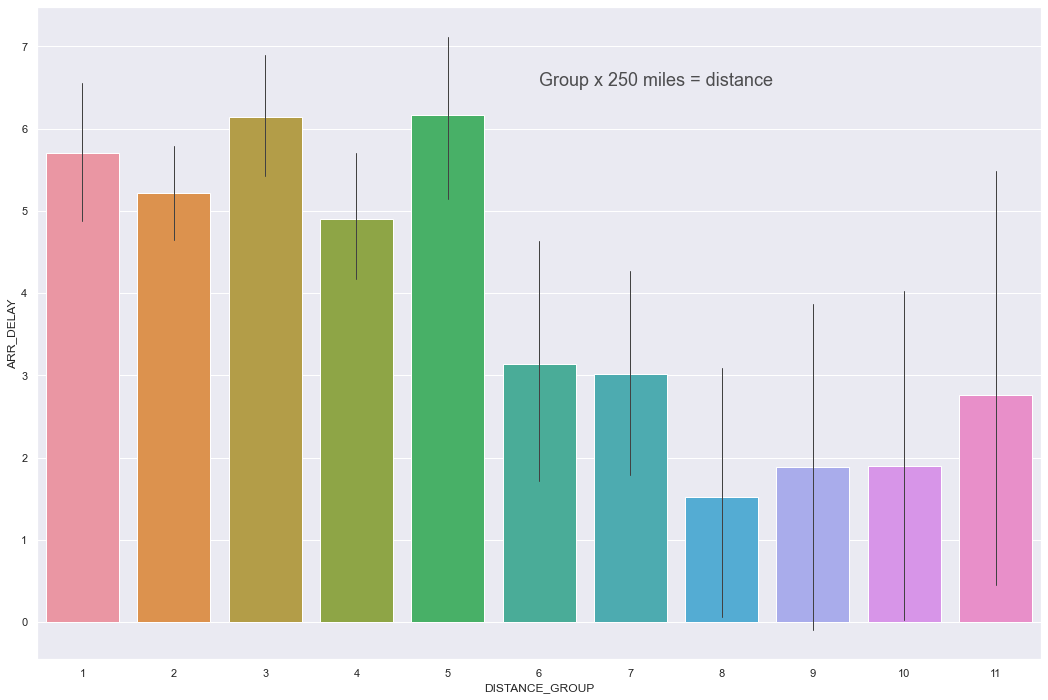

In [606]:
fig, ax = plt.subplots(figsize=(18,12))

sns.barplot(
    ax=ax, 
    x='DISTANCE_GROUP', y='ARR_DELAY', 
    data=sample, 
    errwidth=1)

ax.text(
    s='Group x 250 miles = distance', 
    fontsize=18, 
    x = 0.5, 
    y = 0.9, 
    ha='left', 
    va='top', 
    alpha=0.8, 
    transform=ax.transAxes)

plt.show()

As we guessed earlier, shorter flights are more delayed than longer flights -- possibly, the longer flight time gives pilots more opportunity to make up for any departure delays. 

Let's test our hypothesis by calculating flight speeds and looking at whether there is a difference in speed between flights that departed late vs. not. 

In [658]:
sample['SCHED_SPEED'] = sample['DISTANCE'] / sample['CRS_ELAPSED_TIME']
sample['ACTUAL_SPEED'] = sample['DISTANCE'] / sample['ACTUAL_ELAPSED_TIME']
sample['DIFF_SPEED'] = sample['ACTUAL_SPEED'] - sample['SCHED_SPEED']

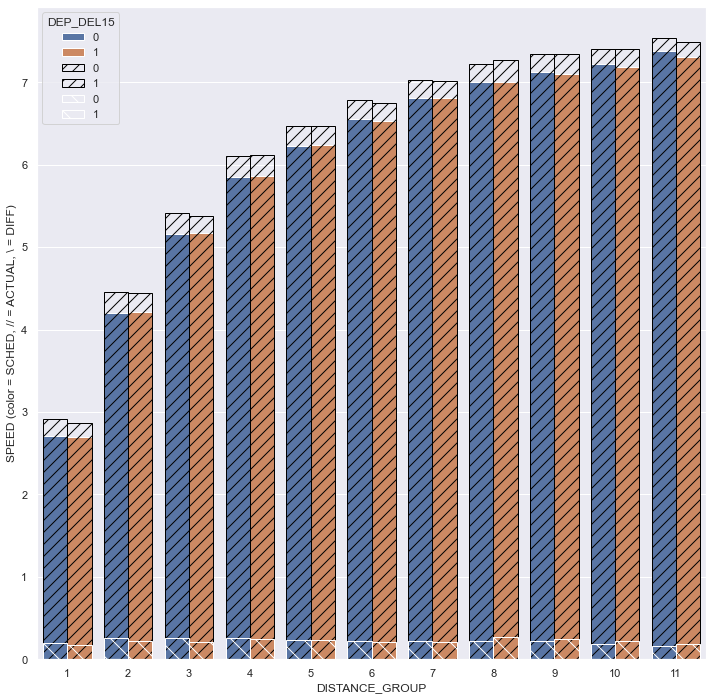

In [690]:
fig, ax = plt.subplots(figsize=(12,12))

sns.barplot(
    ax=ax, 
    x='DISTANCE_GROUP', y='SCHED_SPEED', 
    hue='DEP_DEL15', 
    data=sample, 
    ci=None)

sns.barplot(
    ax=ax, 
    x='DISTANCE_GROUP', 
    y='ACTUAL_SPEED', 
    hue='DEP_DEL15', 
    data=sample, 
    ci=None, fill=False, hatch='//', edgecolor=['#000'])

sns.barplot(
    ax=ax, 
    x='DISTANCE_GROUP', 
    y='DIFF_SPEED', 
    hue='DEP_DEL15', 
    data=sample, 
    ci=None, fill=False, hatch='\\', edgecolor=['#fff'])

ax.set(ylabel='SPEED (color = SCHED, // = ACTUAL, \\ = DIFF)')

plt.show()

Interestingly, actual speed was on average faster than scheduled speed across the board (regardless of whether flight departed late or not). On longer routes, the difference in speed would have had a bigger impact (if you drive 70 mph instead of 60 mph, it won't make much difference on a 60 mile trip -- you reach in 51 minutes instead of 60 minutes -- but would make a huge difference on a 600 mile trip -- you reach in 8.5h instead of 10 hours, a savings of 1.5h). 

## Correlation between properties 

Let's finally check out the correlation between all the columns with a heatmap. First, we will generate a correlation matrix using the `corr` function. Then, we will visualize the correlation matrix with a `heatmap`.

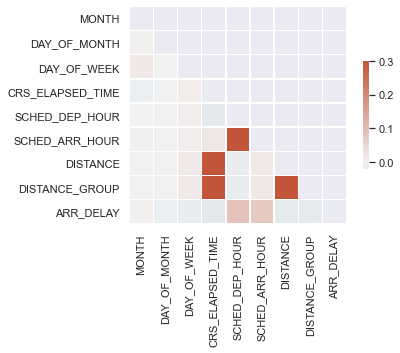

In [636]:
relevant_columns = [
    'MONTH', 'DAY_OF_MONTH', 'DAY_OF_WEEK', 'CRS_ELAPSED_TIME', 
    'SCHED_DEP_HOUR', 'SCHED_ARR_HOUR', 'DISTANCE', 'DISTANCE_GROUP', 
    'ARR_DELAY']

sample['SCHED_DEP_HOUR'] = sample.apply(lambda row: row['SCHED_DEP_TIME'].hour, axis = 1)
sample['SCHED_ARR_HOUR'] = sample.apply(lambda row: row['SCHED_ARR_TIME'].hour, axis = 1)

corr = sample[relevant_columns].corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

sns.heatmap(
    corr, 
    mask=mask, 
    cmap=cmap, 
    vmax=.3, 
    center=0,
    square=True, 
    linewidths=.5, 
    cbar_kws={"shrink": .5})

plt.show()

If we look at the bottom row of the correlation matrix heatmap, we can see how each feature is related to `ARR_DELAY`. Most of the variables are only weakly correlated. Of them, `SCHED_DEP_HOUR`, `SCHED_ARR_HOUR`, and, to a lesser extent, `MONTH` are the most promising. 

Now that we spent all the time understanding the data better, let's get back to the goal of predicting flight delays using linear regression. 

The question after all the visualization is whether linear regression is a good model for predicting delays. The answer seems to be no -- look at the correlation matrix above. Each feature seems to be only vaguely correlated with `ARR_DELAY`. 

So, let's end this project at this point and pick it back up once we have more regression models in our toolkit. 